Домашнее задание № 8
Задание 1 (4 балла)
Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k ) В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

In [ ]:
# импорты:
import torch
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, classification_report
from datasets import load_dataset

In [ ]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip -q

data = pd.read_csv("lenta_40k.csv.zip")

In [ ]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))


filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

# индексируем слова
word2id = {"PAD": 0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [ ]:
# обрабатываем тексты, делаем из них список
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
# словарь меток и обратно
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
def make_labels(target):
    label = label2id[target]
    return label
data['target'] = data.topic.apply(make_labels)
y =data.target.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,stratify=y, random_state=42)

In [ ]:
class OurDataset(Dataset):

  def __init__(self, target_list, token_list, word2id, max_len=128):

    self.target_list = target_list
    self.token_list = token_list
    self.max_len = max_len
    self.word2id = word2id
    self.pad_id = word2id['PAD']

  def __len__(self):

    return len(self.token_list)

  def __getitem__(self, idx):

    tokens = self.token_list[idx]
    tokens = tokens[:self.max_len]
    length = len(tokens)
    if length < self.max_len:
      tokens += [self.pad_id] * (self.max_len - length)

    return torch.tensor(tokens), torch.tensor(self.target_list[idx], dtype=torch.long)

In [ ]:
train_set = OurDataset(y_train, X_train, word2id, MAX_LEN)
test_set = OurDataset(y_test, X_test, word2id, MAX_LEN)


train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size = 1024)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=1024)

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, num_classes, max_len, embedding_dim=30):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        self.lstm_1 = nn.LSTM(input_size=embedding_dim, hidden_size=128, batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)

        self.fc = nn.Linear(128 * 3, num_classes)


    def forward(self, x):
        """
        :param x: Tensor of shape (batch_size, max_len)
        :return: Tensor of shape (batch_size, num_classes)
        """
        x = self.embedding(x)

        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)

        last_state = x[:,-1,:]

        avg_pool = torch.mean(x, dim=1)
        max_pool, _ = torch.max(x, dim=1)

        x = torch.cat([last_state, avg_pool, max_pool], dim=1)

        x = self.fc(x)

        return x


In [ ]:
class NN():

  def __init__(self, model, optimizer, criterion, metric, train_loader, test_loader, num_epochs,scheduler=None, verbose=True, wandb_project=False):
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.metric = metric
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.num_epochs = num_epochs
    self.verbose=verbose
    self.wandb_project=wandb_project
    self.scheduler = None

    self.train_losses = []
    self.val_losses = []
    self.train_metrics = []
    self.val_metrics = []

    if self.wandb_project:
            wandb.init(project="my_nn")
            wandb.watch(self.model)

    self.final_y_true = None
    self.final_y_pred = None



  def train(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

        best_val_loss = float("inf")
        patience_counter = 0
        early_stop_patience = 3

        for epoch in range(1, self.num_epochs + 1):
            self.model.train()
            train_loss = 0.0
            y_true_all, y_pred_all = [], []

            for X_train, y_train in tqdm(self.train_loader, desc=f"Epoch {epoch}/{self.num_epochs}"):
                X_train, y_train = X_train.to(device), y_train.to(device)
                y_pred = self.model(X_train)

                loss = self.criterion(y_pred, y_train)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

                y_true_all.append(y_train.cpu().numpy())
                y_pred_all.append(y_pred.cpu().detach().numpy())

            # Метрики
            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            if self.metric:
                train_metric = self.metric(np.concatenate(y_true_all), np.concatenate(y_pred_all))
                self.train_metrics.append(train_metric)
            else:
                train_metric = train_loss

            # wandb.log({"Train Loss": train_loss, "Train Metric": train_metric})

            # Оценка модели
            val_loss, val_metric, y_true_val, y_pred_val = self.eval(epoch)
            self.val_losses.append(val_loss)
            self.val_metrics.append(val_metric)

            if val_loss < best_val_loss:
              best_val_loss = val_loss
              patience_counter = 0
              self.final_y_true = y_true_val.copy()
              self.final_y_pred = y_pred_val.copy()
              torch.save(self.model.state_dict(), "best_model.pt")
            else:
              patience_counter += 1
              if patience_counter >= early_stop_patience:
                  print(f"\nEarly stopping на эпохе {epoch}, лучшая валидационная loss {best_val_loss:.4f}")
                  break


            # Логирование графиков
            self.plot_losses()

            print(f'loss: {val_loss}, f1: {val_metric}')

            self.print_classification_report()




  def eval(self, epoch):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)
    self.model.eval()


    val_loss = 0.0
    y_true_all, y_pred_all = [], []


    with torch.no_grad():
      for X_test, y_test in tqdm(self.test_loader, desc="Evaluating"):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = self.model(X_test)

        loss = self.criterion(y_pred, y_test)
        val_loss += loss.item()

        y_true_all.append(y_test.cpu().numpy().reshape(-1))
        y_pred_all.append(y_pred.cpu().detach().numpy())

      y_true_all = np.concatenate(y_true_all)
      y_pred_all = np.concatenate(y_pred_all)


    val_loss /= len(self.test_loader)


    if self.metric:
            val_metric = self.metric(y_true_all, y_pred_all)
    else:
            val_metric = val_loss


    if self.scheduler is not None:
      self.scheduler.step(val_loss)

    return val_loss, val_metric, y_true_all, y_pred_all

  def plot_losses(self):
        clear_output()
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        axs[0].plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
        axs[0].plot(range(1, len(self.val_losses) + 1), self.val_losses, label="Validation Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        axs[1].plot(range(1, len(self.train_metrics) + 1), self.train_metrics, label="Train Metric")
        axs[1].plot(range(1, len(self.val_metrics) + 1), self.val_metrics, label="Validation Metric")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Metric")
        axs[1].legend()
        plt.show()
        plt.tight_layout()
        # wandb.log({"loss_plot": wandb.Image(fig)})  # Логируем график в WandB

  def print_classification_report(self):
      if self.final_y_true is None or self.final_y_pred is None:
        print("Нет сохранённых данных для отчёта.")
        return

      y_pred_labels = self.final_y_pred.argmax(axis=1)
      labels=list(range(len(id2label)))

      print("\n=== Classification Report (по лучшей модели) ===\n")
      print(classification_report(
        self.final_y_true,
        y_pred_labels,
        target_names=[id2label[i] for i in range(len(id2label))],
        labels = labels,
        zero_division=0
        ))

In [ ]:
from sklearn.metrics import f1_score

def macro_f1(y_true, y_pred_probs):
    y_pred = y_pred_probs.argmax(axis=1)
    return f1_score(y_true, y_pred, average='macro')


model = LanguageModel(
    vocab_size=len(word2id),
    num_classes=len(label2id),
    max_len=MAX_LEN
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.5, patience=3)
metric = macro_f1

In [ ]:
trainer = NN(model=model,
                optimizer=optimizer,
                criterion=criterion,
            	  scheduler = scheduler,
                metric=metric,
                num_epochs=num_epochs,
                wandb_project=False,
                train_loader=train_loader,
                test_loader=test_loader)

<Figure size 640x480 with 0 Axes>

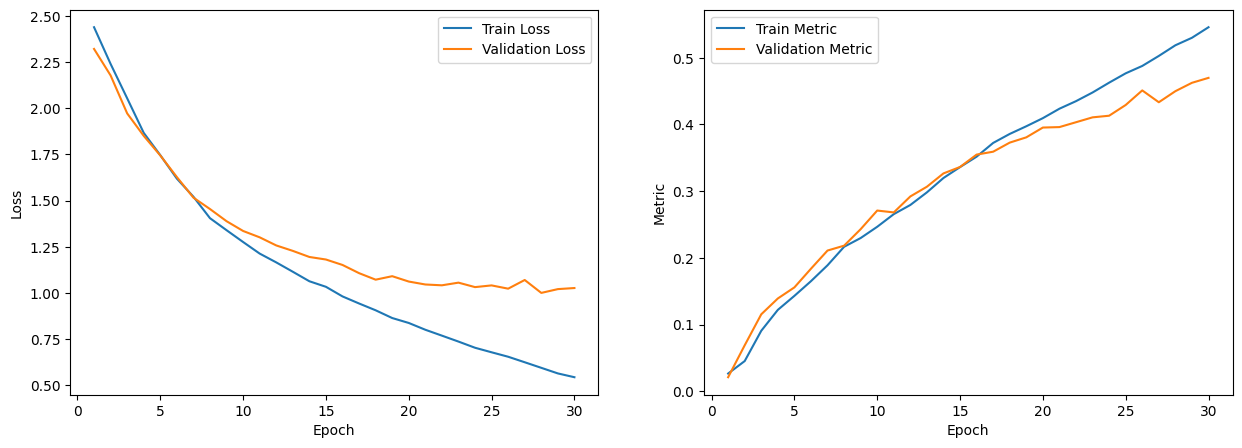

loss: 1.0270198384920757, f1: 0.4698046243638636

=== Classification Report (по лучшей модели) ===

                   precision    recall  f1-score   support

        Экономика       0.75      0.75      0.75       239
  Наука и техника       0.75      0.72      0.73       160
   69-я параллель       0.00      0.00      0.00         4
       Библиотека       0.00      0.00      0.00         0
         Из жизни       0.37      0.46      0.41        84
   Интернет и СМИ       0.42      0.37      0.40       132
          Легпром       0.00      0.00      0.00         0
            Спорт       0.95      0.94      0.95       195
              Мир       0.74      0.73      0.73       410
      Бывший СССР       0.74      0.70      0.72       159
           Бизнес       0.00      0.00      0.00        22
    Культпросвет        0.00      0.00      0.00         1
           Россия       0.70      0.77      0.73       481
      Путешествия       0.17      0.10      0.12        21
         Ценно

Epoch 31/50:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Early stopping на эпохе 31, лучшая валидационная loss 1.0006


<Figure size 640x480 with 0 Axes>

In [ ]:
trainer.train()

# ***МОДЕЛЬ 2***

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, num_classes, max_len, embedding_dim=30):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        self.lstm_1 = nn.LSTM(input_size=embedding_dim, hidden_size=128, batch_first=True, bidirectional=True)

        self.lstm_2 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(256 * 3, num_classes)


    def forward(self, x):
        """
        :param x: Tensor of shape (batch_size, max_len)
        :return: Tensor of shape (batch_size, num_classes)
        """
        x = self.embedding(x)

        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)

        last_state = x[:,-1,:]

        avg_pool = torch.mean(x, dim=1)
        max_pool, _ = torch.max(x, dim=1)

        x = torch.cat([last_state, avg_pool, max_pool], dim=1)

        x = self.fc(x)

        return x


In [ ]:
from sklearn.metrics import f1_score

def macro_f1(y_true, y_pred_probs):
    y_pred = y_pred_probs.argmax(axis=1)
    return f1_score(y_true, y_pred, average='macro')


model = LanguageModel(
    vocab_size=len(word2id),
    num_classes=len(label2id),
    max_len=MAX_LEN,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.5, patience=3)
metric = macro_f1

In [ ]:
trainer = NN(model=model,
                optimizer=optimizer,
                criterion=criterion,
            	  scheduler = scheduler,
                metric=metric,
                num_epochs=num_epochs,
                wandb_project=False,
                train_loader=train_loader,
                test_loader=test_loader)

<Figure size 640x480 with 0 Axes>

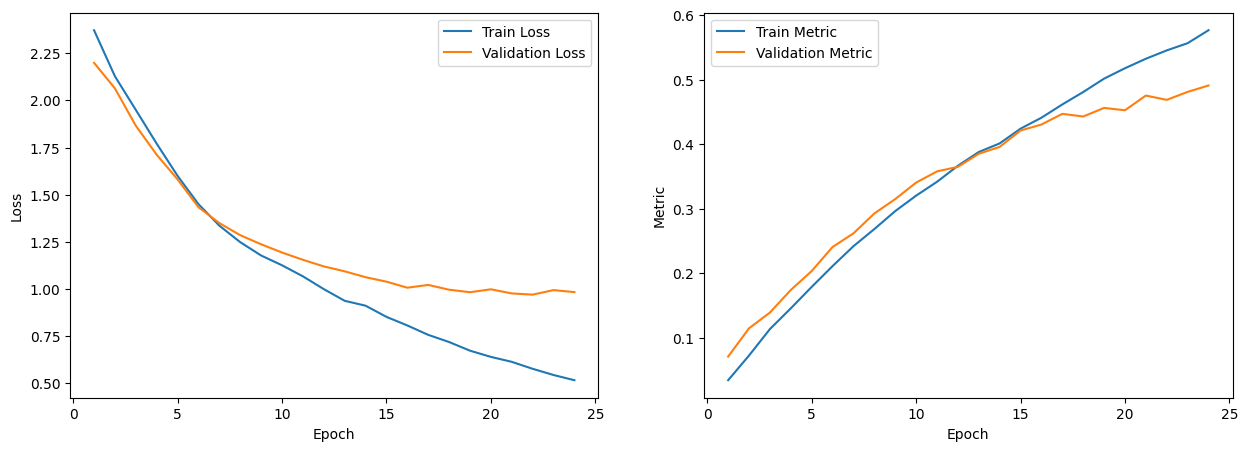

loss: 0.9832445780436198, f1: 0.4908413140501499

=== Classification Report (по лучшей модели) ===

                   precision    recall  f1-score   support

        Экономика       0.72      0.76      0.74       239
  Наука и техника       0.66      0.73      0.70       160
   69-я параллель       0.00      0.00      0.00         4
       Библиотека       0.00      0.00      0.00         0
         Из жизни       0.47      0.40      0.44        84
   Интернет и СМИ       0.43      0.43      0.43       132
          Легпром       0.00      0.00      0.00         0
            Спорт       0.95      0.94      0.95       195
              Мир       0.77      0.74      0.75       410
      Бывший СССР       0.63      0.65      0.64       159
           Бизнес       0.29      0.09      0.14        22
    Культпросвет        0.00      0.00      0.00         1
           Россия       0.69      0.76      0.72       481
      Путешествия       0.21      0.14      0.17        21
         Ценно

Epoch 25/50:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Early stopping на эпохе 25, лучшая валидационная loss 0.9698


<Figure size 640x480 with 0 Axes>

In [ ]:
trainer.train()

# ***Задание 2 (6 баллов)***
На данных википедии (wikiann) обучите и сравните 3 модели:

модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM

модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать

модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг

Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [1]:
pip install --upgrade datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_m

In [2]:
# импорты:
import torch
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, classification_report
from datasets import load_dataset

In [3]:
from datasets import load_dataset
import datasets

dataset = load_dataset("tner/wikiann", "ru", download_mode="force_redownload")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikiann.py: 0.00B [00:00, ?B/s]

wikiann.py: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


test.jsonl:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
vocab = Counter()

for sent in dataset["train"]["tokens"]:
    vocab.update([x.lower() for x in sent])

word2id = {"PAD": 0, "UNK": 1}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for sent in dataset["train"]["tokens"]:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

X_test = []

for sent in dataset["test"]["tokens"]:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

MAX_LEN = max(len(x) for x in X)


label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in label2id.items()}

In [5]:
y_train, y_test = dataset["train"]["tags"], dataset["test"]["tags"]


In [6]:
len(X_test)==len(y_test)

True

In [7]:
class OurDataset(Dataset):

  def __init__(self, target_list, token_list, word2id, label2id, max_len=128):

    self.target_list = target_list
    self.token_list = token_list
    self.max_len = max_len
    self.word2id = word2id
    self.pad_id = word2id['PAD']
    self.label_pad = label2id['PAD']


  def __len__(self):

    return len(self.token_list)

  def __getitem__(self, idx):

    tokens = self.token_list[idx]
    tokens = tokens[:self.max_len]
    length = len(tokens)
    if length < self.max_len:
      tokens += [self.pad_id] * (self.max_len - length)

    tags = self.target_list[idx]
    tags = tags[:self.max_len]
    length = len(tags)
    if length < self.max_len:
      tags += [self.label_pad] * (self.max_len - length)


    return torch.tensor(tokens), torch.tensor(tags)

In [8]:
train_set = OurDataset(y_train, X, word2id,label2id, MAX_LEN,  )
test_set = OurDataset(y_test, X_test, word2id, label2id,MAX_LEN,)


train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size = 1024)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=1024)

In [37]:
class LanguageModel_GRU(nn.Module):
    def __init__(self, vocab_size, num_classes, max_len, embedding_dim=100):
        super(LanguageModel_GRU, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=128, batch_first=True)
        self.lstm_1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)

        self.fc = nn.Linear(128, num_classes)


    def forward(self, x):
        """
        :param x: Tensor of shape (batch_size, max_len)
        :return: Tensor of shape (batch_size, num_classes)
        """
        x = self.embedding(x)

        x, _ = self.gru(x)
        x, _ = self.lstm_1(x)

        # last_state = x[:,-1,:]

        # avg_pool = torch.mean(x, dim=1)
        # max_pool, _ = torch.max(x, dim=1)

        # x = torch.cat([last_state, avg_pool, max_pool], dim=1)

        x = self.fc(x)


        return x


In [38]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [39]:
class NN():

  def __init__(self, model, optimizer, criterion, metric, train_loader, test_loader, num_epochs,
               scheduler=None, verbose=True, wandb_project=False):
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.metric = metric
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.num_epochs = num_epochs
    self.verbose = verbose
    self.wandb_project = wandb_project
    self.scheduler = scheduler

    self.train_losses = []
    self.val_losses = []
    self.train_metrics = []
    self.val_metrics = []

    if self.wandb_project:
      wandb.init(project="my_nn")
      wandb.watch(self.model)

    self.final_y_true = None
    self.final_y_pred = None


  def train(self):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0
    early_stop_patience = 3

    for epoch in range(1, self.num_epochs + 1):
      self.model.train()
      train_loss = 0.0
      y_true_all, y_pred_all = [], []

      for X_train, y_train in tqdm(self.train_loader, desc=f"Epoch {epoch}/{self.num_epochs}"):
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = self.model(X_train)  # [B, T, C]
        loss = self.criterion(
          y_pred.view(-1, y_pred.shape[-1]),  # [B*T, C]
          y_train.view(-1)                   # [B*T]
        )

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        train_loss += loss.item()

        y_true_all.append(y_train.cpu().numpy().reshape(-1))
        y_pred_all.append(y_pred.cpu().detach().numpy())

      # Метрики
      y_true_all = np.concatenate(y_true_all)
      y_pred_all = np.concatenate(y_pred_all).reshape(-1, y_pred_all[0].shape[-1])
      y_pred_all = y_pred_all.argmax(axis=1)

      train_loss /= len(self.train_loader)
      self.train_losses.append(train_loss)

      if self.metric:
        train_metric = self.metric(y_true_all, y_pred_all)
        self.train_metrics.append(train_metric)
      else:
        train_metric = train_loss

      val_loss, val_metric, y_true_val, y_pred_val = self.eval(epoch)
      self.val_losses.append(val_loss)
      self.val_metrics.append(val_metric)

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        self.final_y_true = y_true_val.copy()
        self.final_y_pred = y_pred_val.copy()
        torch.save(self.model.state_dict(), "best_model.pt")
      else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
          print(f"\nEarly stopping на эпохе {epoch}, лучшая валидационная loss {best_val_loss:.4f}")
          break

      self.plot_losses()
      print(f'loss: {val_loss:.4f}, metric: {val_metric:.4f}')
      self.print_classification_report()


  def eval(self, epoch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)
    self.model.eval()

    val_loss = 0.0
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
      for X_test, y_test in tqdm(self.test_loader, desc="Evaluating"):
        X_test, y_test = X_test.to(device), y_test.to(device)

        y_pred = self.model(X_test)

        loss = self.criterion(
          y_pred.view(-1, y_pred.shape[-1]),  # [B*T, C]
          y_test.view(-1)                    # [B*T]
        )
        val_loss += loss.item()

        y_true_all.append(y_test.cpu().numpy().reshape(-1))
        y_pred_all.append(y_pred.cpu().detach().numpy())

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all).reshape(-1, y_pred_all[0].shape[-1])
    y_pred_all = y_pred_all.argmax(axis=1)

    val_loss /= len(self.test_loader)

    if self.metric:
      val_metric = self.metric(y_true_all, y_pred_all)
    else:
      val_metric = val_loss

    if self.scheduler is not None:
      self.scheduler.step(val_loss)

    return val_loss, val_metric, y_true_all, y_pred_all


  def plot_losses(self):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
    axs[0].plot(range(1, len(self.val_losses) + 1), self.val_losses, label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(range(1, len(self.train_metrics) + 1), self.train_metrics, label="Train Metric")
    axs[1].plot(range(1, len(self.val_metrics) + 1), self.val_metrics, label="Validation Metric")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Metric")
    axs[1].legend()

    plt.show()
    plt.tight_layout()


  def print_classification_report(self):
    if self.final_y_true is None or self.final_y_pred is None:
      print("Нет сохранённых данных для отчёта.")
      return

    y_pred_labels = self.final_y_pred
    mask = self.final_y_true != label2id['PAD']
    print("\n=== Classification Report (по лучшей модели) ===\n")
    print(classification_report(
      self.final_y_true[mask],
      y_pred_labels[mask],
      target_names=[id2labels[i] for i in range(len(id2labels))],
      labels=list(range(len(id2labels))),
      zero_division=0
    ))


In [44]:
from sklearn.metrics import accuracy_score

model1 = LanguageModel_GRU(
    vocab_size=len(word2id),
    num_classes=len(label2id),
    max_len=MAX_LEN,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=label2id["PAD"])
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
num_epochs = 50
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.5, patience=3)
metric = accuracy_score

In [46]:
trainer1 = NN(model=model1,
                optimizer=optimizer,
                criterion=criterion,
            	  scheduler = scheduler,
                metric=metric,
                num_epochs=num_epochs,
                wandb_project=False,
                train_loader=train_loader,
                test_loader=test_loader)

<Figure size 640x480 with 0 Axes>

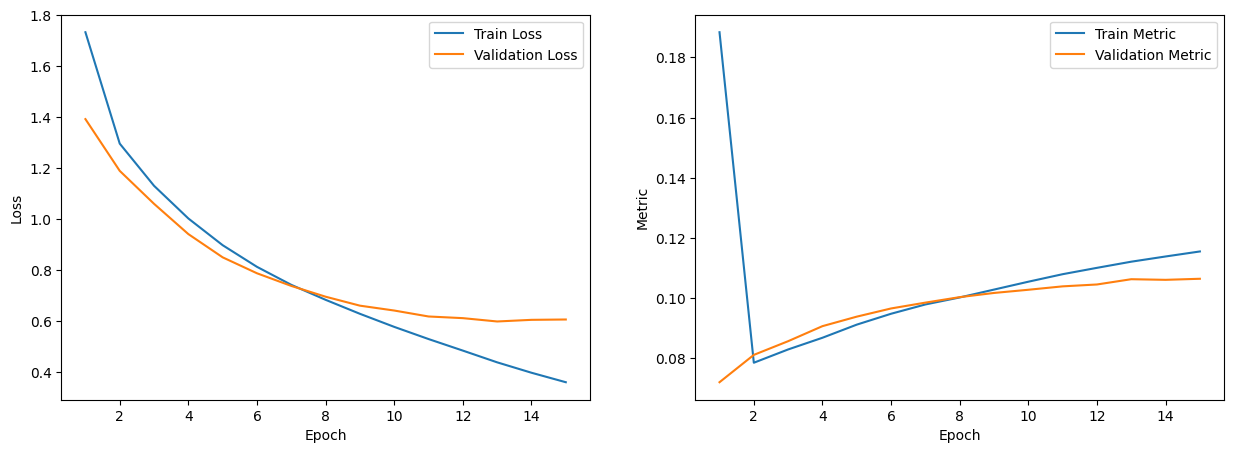

loss: 0.6062, metric: 0.1065

=== Classification Report (по лучшей модели) ===

              precision    recall  f1-score   support

       B-LOC       0.57      0.51      0.54      4559
       B-ORG       0.56      0.37      0.45      4074
       B-PER       0.50      0.63      0.55      3543
       I-LOC       0.71      0.62      0.66      3060
       I-ORG       0.75      0.67      0.71      8008
       I-PER       0.92      0.81      0.86      7544
           O       0.87      0.94      0.90     40480
         PAD       0.00      0.00      0.00         0

    accuracy                           0.81     71268
   macro avg       0.61      0.57      0.58     71268
weighted avg       0.80      0.81      0.80     71268



Epoch 16/50:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Early stopping на эпохе 16, лучшая валидационная loss 0.5985


<Figure size 640x480 with 0 Axes>

In [47]:
trainer1.train()

## **модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать**

In [28]:
class ResidualRNNModel(nn.Module):
    def __init__(self, vocab_size, num_classes, embedding_dim=128, hidden_size=128, max_len=128):
        super(ResidualRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.rnn3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        emb = self.embedding(x)  # (B, T, D)

        out1, _ = self.rnn1(emb)  # (B, T, H)


        out2_input = out1 + emb  # (B, T, H)
        out2, _ = self.rnn2(out2_input)


        out3_input = out2 + emb  # (B, T, H)
        out3, _ = self.rnn3(out3_input)

        logits = self.fc(out3)  # (B, T, C)
        return logits


In [48]:
model2 = ResidualRNNModel(
    vocab_size=len(word2id),
    num_classes=len(label2id),
    max_len=MAX_LEN,
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=label2id["PAD"])
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 50
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.5, patience=3)
metric = accuracy_score


In [49]:
trainer = NN(model=model2,
                optimizer=optimizer,
                criterion=criterion,
            	  scheduler = scheduler,
                metric=metric,
                num_epochs=num_epochs,
                wandb_project=False,
                train_loader=train_loader,
                test_loader=test_loader)

<Figure size 640x480 with 0 Axes>

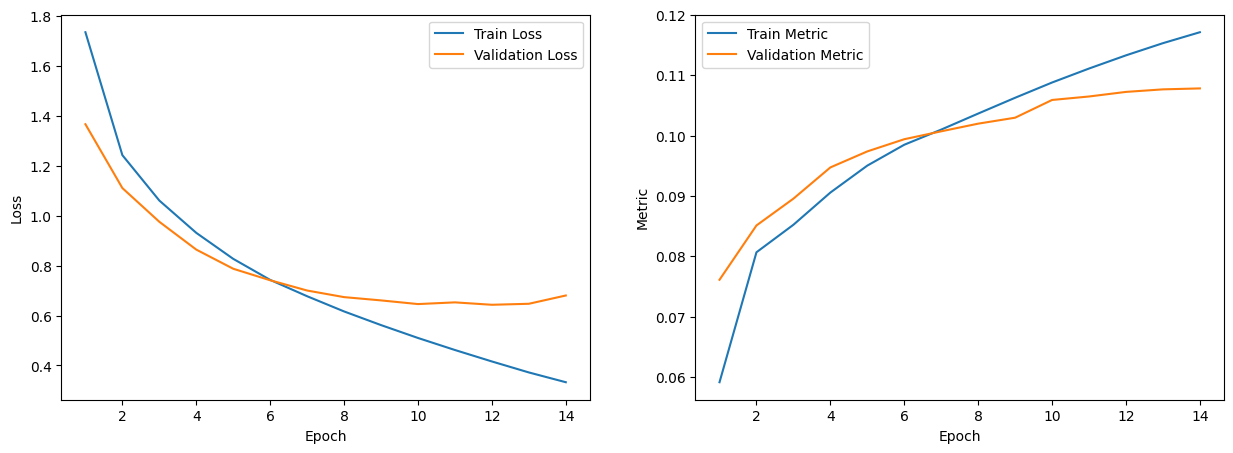

loss: 0.6802, metric: 0.1078

=== Classification Report (по лучшей модели) ===

              precision    recall  f1-score   support

       B-LOC       0.74      0.42      0.54      4559
       B-ORG       0.62      0.33      0.43      4074
       B-PER       0.51      0.75      0.61      3543
       I-LOC       0.85      0.48      0.61      3060
       I-ORG       0.76      0.68      0.72      8008
       I-PER       0.90      0.85      0.87      7544
           O       0.85      0.96      0.90     40480
         PAD       0.00      0.00      0.00         0

    accuracy                           0.81     71268
   macro avg       0.65      0.56      0.58     71268
weighted avg       0.81      0.81      0.80     71268



Epoch 15/50:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Early stopping на эпохе 15, лучшая валидационная loss 0.6430


<Figure size 640x480 with 0 Axes>

In [50]:
trainer.train()

In [53]:
import torch
import torch.nn as nn

class CNN_RNN_Model(nn.Module):
    def __init__(self, vocab_size, num_classes, embedding_dim=128, hidden_size=128, max_len=128):
        super(CNN_RNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=embedding_dim, kernel_size=3, padding=1)  # out = emb_dim
        self.relu2 = nn.ReLU()

        self.rnn1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.rnn2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        emb = self.embedding(x)  # (B, T, D)

        cnn_input = emb.transpose(1, 2)  # (B, D, T)

        cnn_out = self.relu1(self.conv1(cnn_input))  # (B, 128, T)
        cnn_out = self.relu2(self.conv2(cnn_out))    # (B, D, T)

        cnn_out = cnn_out.transpose(1, 2)  # (B, T, D)

        rnn_out1, _ = self.rnn1(cnn_out)
        rnn_out2, _ = self.rnn2(rnn_out1)

        logits = self.fc(rnn_out2)  # (B, T, num_classes)
        return logits


In [54]:
model3 = CNN_RNN_Model(
    vocab_size=len(word2id),
    num_classes=len(label2id),
    max_len=MAX_LEN,
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=label2id["PAD"])
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
num_epochs = 50
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.5, patience=3)
metric = accuracy_score


In [55]:
trainer3 = NN(model=model3,
                optimizer=optimizer,
                criterion=criterion,
            	  scheduler = scheduler,
                metric=metric,
                num_epochs=num_epochs,
                wandb_project=False,
                train_loader=train_loader,
                test_loader=test_loader)

<Figure size 640x480 with 0 Axes>

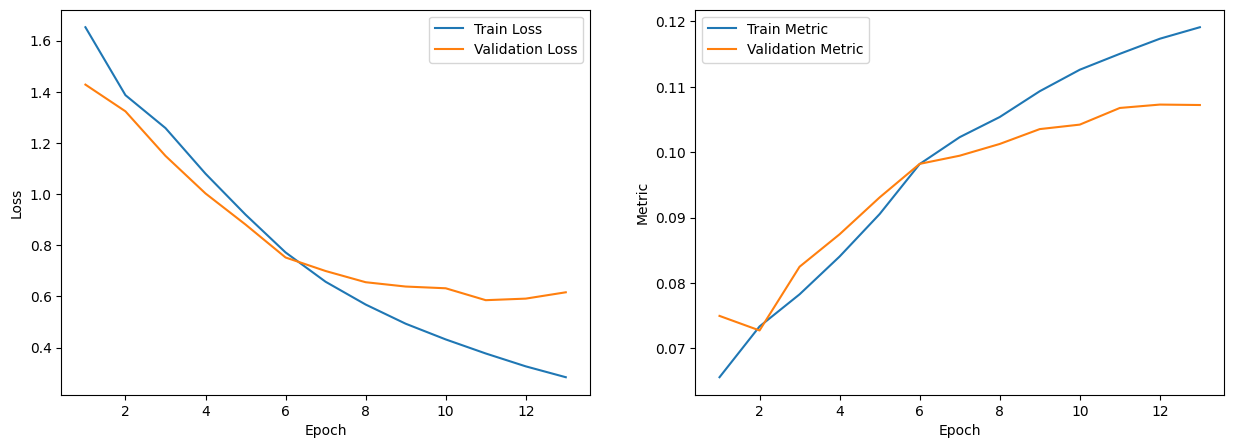

loss: 0.6163, metric: 0.1072

=== Classification Report (по лучшей модели) ===

              precision    recall  f1-score   support

       B-LOC       0.57      0.65      0.61      4559
       B-ORG       0.48      0.50      0.49      4074
       B-PER       0.90      0.75      0.82      3543
       I-LOC       0.68      0.59      0.64      3060
       I-ORG       0.57      0.79      0.66      8008
       I-PER       0.92      0.84      0.88      7544
           O       0.93      0.88      0.90     40480
         PAD       0.00      0.00      0.00         0

    accuracy                           0.81     71268
   macro avg       0.63      0.63      0.62     71268
weighted avg       0.83      0.81      0.82     71268



Epoch 14/50:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Early stopping на эпохе 14, лучшая валидационная loss 0.5855


<Figure size 640x480 with 0 Axes>

In [56]:
trainer3.train()

In [ ]:
# | метрики     | Model 1  | Model 2 | Model 3  |
# | ----------- | -------- | ------- | -------- |
# | Accuracy    | 0.81     | 0.81    |   0.84  |
# | Macro F1    | 0.60     | 0.58    |   0.64  |
# | Weighted F1 | 0.81     | 0.80    |   0.83  |
# ВИДИМ, что модель 3 и 1 сопоставимы по качеству и работают одинаково хорошо, модель 2 по всем метрикам хуже,


In [58]:
def predict_tags(model, text, word2id, id2label, max_len=128, device='cuda'):
    model.eval()
    model.to(device)
    tokens, ids = tokenize(text, word2id)
    ids_tensor = torch.tensor([ids[:max_len] + [word2id["PAD"]] * (max_len - len(ids))]).to(device)
    with torch.no_grad():
        outputs = model(ids_tensor)
        pred = outputs.argmax(dim=-1)[0][:len(ids)]
        tags = [id2label[idx] for idx in pred.cpu().numpy()]
    return list(zip(tokens, tags))

In [63]:
text1 = "Я работал в Apple в Москве, но потом переехал в Париж и устроился в Газпромбанк."
text2 = "Я встретил Розу в саду, а потом отправился в банк Тинькофф через Парк Горького."
text3 = "Президент компании Samsung Electronics Синь Дзинь Пинь посетил Токио на встрече G7."
text4 = "Компания ООО Рога и Копыта решили купить завод по изготовлению левой палочки Twix"


In [64]:
texts = [text1, text2, text3, text4]
models = [model1, model2, model3]
model_names = ["GRU+LSTM", "ResidualRNN", "CNN+RNN"]

for text in texts:
    print(f"\nТекст: {text}")
    for m, name in zip(models, model_names):
        print(f"\nМодель: {name}")
        tags = predict_tags(m, text, word2id, id2labels, MAX_LEN)
        print(" ".join([f"{token}({tag})" for token, tag in tags]))



Текст: Я работал в Apple в Москве, но потом переехал в Париж и устроился в Газпромбанк.

Модель: GRU+LSTM
Я(O) работал(O) в(O) Apple(B-ORG) в(O) Москве(B-LOC) ,(O) но(O) потом(O) переехал(O) в(O) Париж(B-LOC) и(O) устроился(B-LOC) в(O) Газпромбанк(B-LOC) .(O)

Модель: ResidualRNN
Я(B-ORG) работал(O) в(O) Apple(O) в(O) Москве(B-LOC) ,(O) но(O) потом(O) переехал(O) в(O) Париж(B-LOC) и(O) устроился(B-LOC) в(O) Газпромбанк(O) .(O)

Модель: CNN+RNN
Я(O) работал(O) в(O) Apple(O) в(O) Москве(B-LOC) ,(O) но(O) потом(O) переехал(O) в(O) Париж(B-LOC) и(O) устроился(O) в(O) Газпромбанк(B-LOC) .(O)

Текст: Я встретил Розу в саду, а потом отправился в банк Тинькофф через Парк Горького.

Модель: GRU+LSTM
Я(O) встретил(I-ORG) Розу(I-ORG) в(O) саду(I-ORG) ,(O) а(O) потом(O) отправился(O) в(O) банк(B-LOC) Тинькофф(O) через(O) Парк(B-LOC) Горького(I-ORG) .(O)

Модель: ResidualRNN
Я(B-ORG) встретил(I-ORG) Розу(I-ORG) в(O) саду(O) ,(O) а(O) потом(O) отправился(O) в(O) банк(O) Тинькофф(O) через(O) Парк(B-

**GRU+LSTM**: Узнаёт классические организации, географию
                    
**ResidualRNN**	Хорошо работает с оф.названиями (Samsung) но не понимает имена и банк

**CNN+RNN**:	Иногда угадывает нестандартные ORG по контексту (Газпромбанк), много ложных срабатываний (Twix, G7) - определяет какLOC